In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt
from matplotlib import*
import matplotlib
from matplotlib.pyplot import *
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import Adam # I believe this is better optimizer for our case
from keras.preprocessing.image import ImageDataGenerator # to augmenting our images for increasing accuracy
from keras.utils.vis_utils import plot_model
import scipy
from sklearn.model_selection import train_test_split # to split our train data into train and validation sets
import numpy as np # linear algebra
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt
from matplotlib import*
import matplotlib
from matplotlib.pyplot import *
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
print(tf.__version__)

2.4.1


In [ ]:
zip_file = tf.keras.utils.get_file(origin='https://github.com/lizu444/breast-cancer-data/raw/main/breast%20cancer.zip', 
                                   fname='datasetv2.zip', extract=True)

1695744/1690207 [==============================] - 0s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/breast cancer.zip"


Archive:  /content/drive/MyDrive/breast cancer.zip
replace Images/train/benign/mdb002rl_resized.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Images/train/benign/mdb002rl_resized.jpg  
  inflating: Images/train/benign/mdb003ll_resized.jpg  
  inflating: Images/train/benign/mdb005ll_resized.jpg  
  inflating: Images/train/benign/mdb007ll_resized.jpg  
  inflating: Images/train/benign/mdb008rl_resized.jpg  
  inflating: Images/train/benign/mdb011ll_resized.jpg  
  inflating: Images/train/benign/mdb012rl_resized.jpg  
  inflating: Images/train/benign/mdb013ll_resized.jpg  
  inflating: Images/train/benign/mdb016rm_resized.jpg  
  inflating: Images/train/benign/mdb017ls_resized.jpg  
  inflating: Images/train/benign/mdb018rs_resized.jpg  
  inflating: Images/train/benign/mdb019ll_resized.jpg  
  inflating: Images/train/benign/mdb020rl_resized.jpg  
  inflating: Images/train/benign/mdb021ll_resized.jpg  
  inflating: Images/train/benign/mdb022rm_resized.jpg  
  inflating: Images

In [ ]:
data_dir = os.path.join(os.path.dirname(zip_file), '/content/Images')
train_dir = os.path.join(data_dir, '/content/Images/train')
validation_dir = os.path.join(data_dir, '/content/Images/validation')


In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /content/Images/train : 256files
total images for validation : /content/Images/validation : 64files


**Create a dataset**

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

**use 70% of the images for training, and 30% for validation**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  #label_mode='binary',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 320 files belonging to 2 classes.
Using 224 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  #label_mode='binary',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 320 files belonging to 2 classes.
Using 96 files for validation.


**class_names attribute on these datasets**

In [ ]:
class_names = train_ds.class_names
print(class_names)

['train', 'validation']


**Visualize the data**

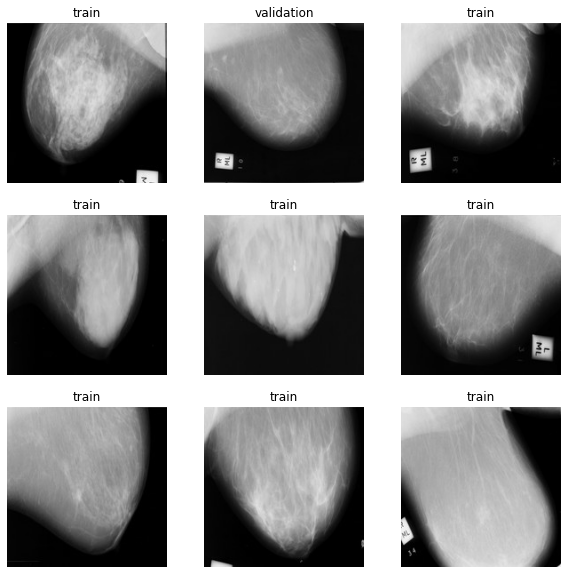

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**the dataset and retrieve batches of image**

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  

  break

(32, 180, 180, 3)
(32,)


**Configure the dataset for performance**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardize the data The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.**

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

**Maping the data**

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9058824


**Data augmentation**

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

**visualize what a few augmented examples look like by applying data augmentation to the same image several times**

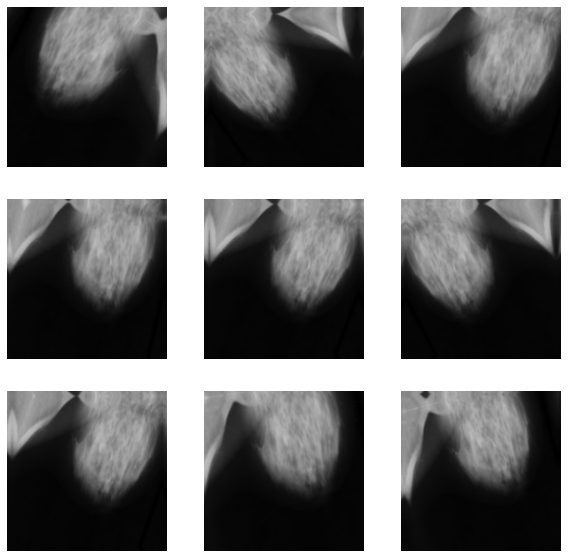

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**My Model**

In [ ]:
def Mynew_CNNmodel():

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(img_height, img_width, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
              loss='binary_crossentropy', # loss='categorical_crossentropy' if softmax
              metrics=['accuracy',tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    label_weights=None,
),tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
),tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
),tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)])

  return model

In [ ]:
model=Mynew_CNNmodel()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 180, 180, 8)       224       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 8)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 90, 90, 8)         32        
_________________________________________________________________
dropout_4 (Dropout)          (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        2336      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 45, 45, 32)       

In [ ]:
new_model=Mynew_CNNmodel()
new_hist=new_model.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10
7/7 [==============================] - 3s 140ms/step - loss: 10.8194 - accuracy: 0.5675 - auc_5: 0.4861 - precision_5: 0.2493 - recall_5: 0.3722 - true_positives_5: 11.3750 - true_negatives_5: 67.3750 - false_positives_5: 39.1250 - false_negatives_5: 22.1250 - val_loss: 15.6835 - val_accuracy: 0.5104 - val_auc_5: 0.4469 - val_precision_5: 0.1190 - val_recall_5: 0.3333 - val_true_positives_5: 5.0000 - val_true_negatives_5: 44.0000 - val_false_positives_5: 37.0000 - val_false_negatives_5: 10.0000
Epoch 2/10
7/7 [==============================] - 0s 28ms/step - loss: 0.5947 - accuracy: 0.7986 - auc_5: 0.6530 - precision_5: 0.5510 - recall_5: 0.3231 - true_positives_5: 8.0000 - true_negatives_5: 102.5000 - false_positives_5: 6.7500 - false_negatives_5: 22.7500 - val_loss: 15.1459 - val_accuracy: 0.5938 - val_auc_5: 0.4733 - val_precision_5: 0.1471 - val_recall_5: 0.3333 - val_true_positives_5: 5.0000 - val_true_negatives_5: 52.0000 - val_false_positives_5: 29.0000 - val_false_ne